### 用networkx可视化siesta的input.fdf中的原子结构坐标

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import Voronoi, ConvexHull #用于计算Voronoi图和凸包
from scipy.spatial import voronoi_plot_2d
from collections import Counter

In [20]:
def parse_fdf(filename):
    atoms = []
    box_sizes = []
    with open(filename, 'r') as f:
        lines = f.readlines()
        start, end = 0, 0
        for line in lines:
            if "AtomicCoordinatesAndAtomicSpecies" in line:
                if line.strip().startswith('%block'):
                    start = lines.index(line) + 1
                elif line.strip().startswith('%endblock'):
                    end = lines.index(line)
                    break
        for i in range(start, end):
            parts = lines[i].split()
            x, y, z = float(parts[0]), float(parts[1]), float(parts[2])
            species = int(parts[3])
            atoms.append(np.array([x, y, z, species]))
        start, end = 0, 0
        for line in lines:
            if "LatticeVectors" in line:
                if line.strip().startswith('%block'):
                    start = lines.index(line) + 1
                elif line.strip().startswith('%endblock'):
                    end = lines.index(line)
                    break
        for i in range(start, end):
            parts = lines[i].split()
            a, b, c = float(parts[0]), float(parts[1]), float(parts[2])
            box_sizes.append((a, b, c))
    return np.array(atoms), np.array(box_sizes)

def create_graph(atoms, attr_value):
    G = nx.Graph()
    for i, (x, y, z, species) in enumerate(atoms):
        # attr_value = np.random.random()  # 生成一个随机的 attr 值，可以根据实际需求修改
        G.add_node(i, pos=(x, y, z), attr=attr_value[i], species=species)
    # 添加边的逻辑需要根据具体的需求和阈值来决定，这里假设在某个距离阈值内的原子之间有边。
    threshold = 1.9
    for i in range(len(atoms)):
        for j in range(i + 1, len(atoms)):
            xi, yi, zi, _ = atoms[i]
            xj, yj, zj, _ = atoms[j]
            dist = ((xi - xj) ** 2 + (yi - yj) ** 2 + (zi - zj) ** 2) ** 0.5
            if dist < threshold:
                G.add_edge(i, j)
    return G

#计算每个节点被移除后图的拉普拉斯矩阵的行列式值，来衡量每个节点在图中的重要性。行列式值越大，表示该节点对图的整体结构影响越大。
def calculate_laplacian_centrality(G):
    laplacian_centrality = {}
    L = nx.laplacian_matrix(G).todense()
    for node in G.nodes():
        G_copy = G.copy()
        G_copy.remove_node(node)
        L_copy = nx.laplacian_matrix(G_copy).todense()
        laplacian_centrality[node] = np.linalg.det(L_copy)
    return laplacian_centrality

#画2D图
def visualize_2d_graph(G):
    plt.figure(figsize=(7, 3))
    pos = nx.get_node_attributes(G, 'pos')
    attrs = nx.get_node_attributes(G, 'attr')
    nodes = G.nodes()
    # 直接从pos字典中提取键值对，生成新的字典pos_2d
    pos_2d = {node: coords[:2] for node, coords in pos.items()}

    node_colors = [attrs[node] for node in nodes]  # 使用 attr 值作为颜色
    cmap = plt.cm.coolwarm   # 选择一个颜色映射

    nx.draw(G, pos_2d, with_labels=True, node_size=80, node_color=node_colors, edgecolors="tab:gray", font_size=5, font_weight='bold', width=3, cmap=cmap)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
    sm.set_array([])
    # plt.colorbar(sm, ax=plt.gca(), label='Voronoi Values')
    plt.colorbar(sm, ax=plt.gca(), label='Node feature values')
    plt.show()

def visualize_3d_graph(G):
    pos = nx.get_node_attributes(G, 'pos')
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for node, (x, y, z) in pos.items():
        ax.scatter(x, y, z, s=50)

    for edge in G.edges():
        x = [pos[edge[0]][0], pos[edge[1]][0]]
        y = [pos[edge[0]][1], pos[edge[1]][1]]
        z = [pos[edge[0]][2], pos[edge[1]][2]]
        ax.plot(x, y, z, c='b')

    plt.show()

def visualize_3d_gray_graph(G):
    pos = nx.get_node_attributes(G, 'pos')
    attrs = nx.get_node_attributes(G, 'attr')
    nodes = G.nodes()
    node_colors = [attrs[node] for node in nodes]
    cmap = plt.cm.viridis

    plt.figure(figsize=(10, 4))
    ax = plt.axes(projection='3d')
    for node, (x, y, z) in pos.items():
        ax.scatter(x, y, z, s=100, c=[node_colors[node]], cmap=cmap, edgecolors="tab:gray")
    
    for edge in G.edges():
        x = [pos[edge[0]][0], pos[edge[1]][0]]
        y = [pos[edge[0]][1], pos[edge[1]][1]]
        z = [pos[edge[0]][2], pos[edge[1]][2]]
        ax.plot(x, y, z, c='b')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
    sm.set_array([])
    plt.colorbar(sm, label='Voronoi Values')
    plt.show()


'''
# 计算拉普拉斯矩阵的行列式值
laplacian_centrality = calculate_laplacian_centrality(G)
# print(laplacian_centrality)
# 为每个节点添加 laplacian_属性
for node, value in laplacian_centrality.items():
    nx.set_node_attributes(G, {node: value}, 'attr')
'''

'''
# 计算拉普拉斯中心性
laplacian_centrality = nx.laplacian_centrality(G)
# print(laplacian_centrality)
for node, value in laplacian_centrality.items():
    nx.set_node_attributes(G, {node: value}, 'attr')
# print(laplacian_centrality)
'''


# degree_centrality = nx.degree_centrality(G)
# eigenvector_centrality = nx.eigenvector_centrality(G)
# 将拉普拉斯中心性数据存储到每个节点的 attr 属性中
# for node, value in degree_centrality.items():
#     nx.set_node_attributes(G, {node: value}, 'attr')

"\n# 计算拉普拉斯中心性\nlaplacian_centrality = nx.laplacian_centrality(G)\n# print(laplacian_centrality)\nfor node, value in laplacian_centrality.items():\n    nx.set_node_attributes(G, {node: value}, 'attr')\n# print(laplacian_centrality)\n"

In [52]:
help(plt.cm)

Help on module matplotlib.cm in matplotlib:

NAME
    matplotlib.cm - Builtin colormaps, colormap handling utilities, and the `ScalarMappable` mixin.

DESCRIPTION
    .. seealso::
    
      :doc:`/gallery/color/colormap_reference` for a list of builtin colormaps.
    
      :ref:`colormap-manipulation` for examples of how to make
      colormaps.
    
      :ref:`colormaps` an in-depth discussion of choosing
      colormaps.
    
      :ref:`colormapnorms` for more details about data normalization.

CLASSES
    builtins.object
        ScalarMappable
    collections.abc.Mapping(collections.abc.Collection)
        ColormapRegistry
    
    class ColormapRegistry(collections.abc.Mapping)
     |  ColormapRegistry(cmaps)
     |  
     |  Container for colormaps that are known to Matplotlib by name.
     |  
     |  The universal registry instance is `matplotlib.colormaps`. There should be
     |  no need for users to instantiate `.ColormapRegistry` themselves.
     |  
     |  Read access 

In [4]:
# 主函数
filename = '/fs2/home/ndsim10/all-kinds-test/graphene-defect/mixed_defect/input.fdf'
atoms, box_sizes = parse_fdf(filename)

In [5]:
print(atoms.shape)
coords = atoms[:,:3]
print(coords.shape)

(284, 4)
(284, 3)


In [6]:
# 周期性边界条件的扩展
def extend_coords_periodic(coords, box_sizes, dim):
    extended_coords = []
    shifts = [-1, 0, 1] #通过在三个方向（-1, 0, 1）上进行平移，将原子坐标扩展到更大的区域，以便正确处理边界原子。
    if dim == 2:
        box_size = np.array([box_sizes[0],box_sizes[1]])
        # 提取前两列二维坐标
        for shift_x in shifts:
            for shift_y in shifts:
                shift_vector = np.array([shift_x, shift_y]).reshape(1,2) @ box_size
                extended_coords.append(coords + shift_vector)
    elif dim ==3:
        for shift_x in shifts:
            for shift_y in shifts:
                for shift_z in shifts:
                    shift_vector = np.array([shift_x, shift_y, shift_z]) @ box_sizes
                    extended_coords.append(coords + shift_vector)
    else:
        raise ValueError('Unknown dimension: {}'.format(dim))
    return np.vstack(extended_coords)

dim=2
# 扩展坐标
extended_coords = extend_coords_periodic(coords, box_sizes, dim)
print(extended_coords.shape)

(2556, 3)


[1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1233, 1234, 1235, 1236, 1237, 1238, 1239, 1240, 1241, 1242, 1243, 1244, 1245, 1246, 1247, 1248, 1249, 1250, 1251, 1252, 1253, 1254, 1255, 1256, 1257, 1258, 1259, 1260, 1261, 1262, 1263, 1264, 1265, 1266, 1267, 1268, 1269, 1270, 1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287, 1288, 1289, 1290, 1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1300, 1301, 130

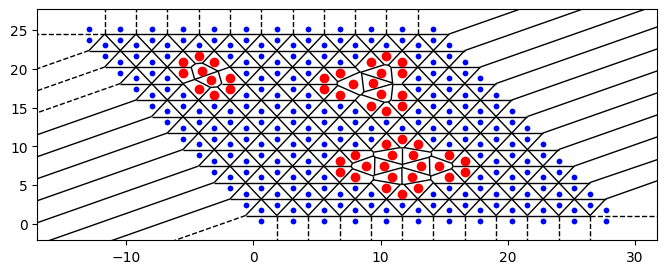

In [10]:
# 提取前两列二维坐标
coords_2d = coords[:, :2]
dim=2
# 扩展坐标
extended_coords = extend_coords_periodic(coords, box_sizes, dim)[:,:2]
# 创建一个字典来存储 a 列表中每个元素的索引
a_dict = {tuple(elem): idx for idx, elem in enumerate(coords_2d)}
b_dict = {tuple(elem): idx for idx, elem in enumerate(extended_coords)}
# 找出 b 列表中元素在 a 列表中的索引
indices = [b_dict[tuple(elem)] for elem in b_dict if elem in a_dict]
print(indices)


# 计算 Voronoi 多边形面积
def calculate_voronoi_areas(extended_coords, indices):
    vor = Voronoi(extended_coords)
    areas = []
    
    for region_index in vor.point_region[indices]: #:len(atoms_2d)
        region = vor.regions[region_index]
        if not -1 in region and len(region) > 0:
            polygon = [vor.vertices[i] for i in region]
            if len(polygon) > 0:
                hull = ConvexHull(polygon)
                area = hull.area
                areas.append(area)
            else:
                areas.append(0)
        else:
            areas.append(0)
    areas = [round(area, 4) for area in areas]
    # 计算每个元素出现的次数
    # counter = Counter(rounded_areas)
    # 找出出现次数最多的元素（排除0）
    # most_common_element = counter.most_common(1)[0][0] if counter.most_common(1)[0][0] != 0 else counter.most_common(2)[1][0]
    # 将列表中的0替换为出现次数最多的元素
    # areas = [most_common_element if x == 0 else x for x in rounded_areas]
    return np.array(areas)

# 计算 Voronoi 多边形面积
areas = np.array(calculate_voronoi_areas(extended_coords, indices))

max_abs_value = np.max(np.abs(areas))
max_abs_normalized = areas / max_abs_value
print(max_abs_normalized)


def most_frequent_index(lst):
    # 计算每种元素的数量
    count = Counter(lst)
    # 找到数量最多的元素
    most_frequent_element = count.most_common(1)[0][0]
    # 找到该元素的所有索引
    most_frequent_indices = [i for i, x in enumerate(lst) if x == most_frequent_element]
    # 找到其他元素的所有索引
    other_indices = [i for i, x in enumerate(lst) if x != most_frequent_element]
    return most_frequent_element, most_frequent_indices, other_indices

# 计算并打印数量最多的元素的索引
most_frequent_element, most_frequent_indices, other_indices = most_frequent_index(areas)
print("数量最多的元素是{},索引为:{}".format(most_frequent_element, most_frequent_indices))
print("其它元素的索引为:{}".format(other_indices))
# for i in other_indices:
#     print(areas[i])

# 可视化 Voronoi 图和缺陷原子
fig, ax = plt.subplots(figsize=(8, 3))

# 绘制 Voronoi 图
vor = Voronoi(coords_2d) #只画原始图
# vor = Voronoi(extended_coords) #画出扩展周期性边界条件的所有图
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='k')

# 高亮缺陷原子
ax.plot(coords[:, 0], coords[:, 1], 'b.')
ax.plot(coords[other_indices, 0], coords[other_indices, 1], 'ro')

plt.show()

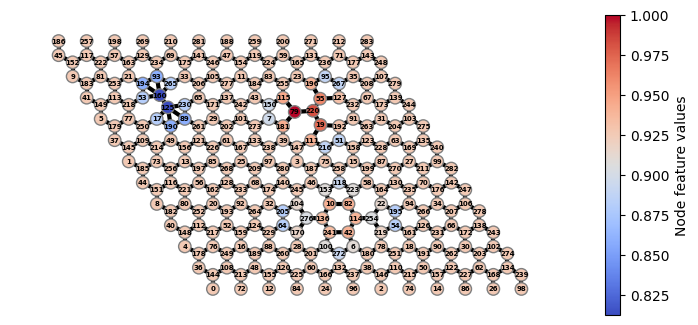

In [21]:
G = create_graph(atoms, max_abs_normalized)

visualize_2d_graph(G)

In [22]:
filename = '/fs2/home/ndsim10/all-kinds-test/mos2_defect/mos2_300_mixed_defect/input.fdf'
atoms, box_sizes = parse_fdf(filename)

In [25]:
print(atoms.shape)
coords = atoms[:,:3]
print(coords.shape)

(296, 4)
(296, 3)


[3848, 3849, 3850, 3851, 3852, 3853, 3854, 3855, 3856, 3857, 3858, 3859, 3860, 3861, 3862, 3863, 3864, 3865, 3866, 3867, 3868, 3869, 3870, 3871, 3872, 3873, 3874, 3875, 3876, 3877, 3878, 3879, 3880, 3881, 3882, 3883, 3884, 3885, 3886, 3887, 3888, 3889, 3890, 3891, 3892, 3893, 3894, 3895, 3896, 3897, 3898, 3899, 3900, 3901, 3902, 3903, 3904, 3905, 3906, 3907, 3908, 3909, 3910, 3911, 3912, 3913, 3914, 3915, 3916, 3917, 3918, 3919, 3920, 3921, 3922, 3923, 3924, 3925, 3926, 3927, 3928, 3929, 3930, 3931, 3932, 3933, 3934, 3935, 3936, 3937, 3938, 3939, 3940, 3941, 3942, 3943, 3944, 3945, 3946, 3947, 3948, 3949, 3950, 3951, 3952, 3953, 3954, 3955, 3956, 3957, 3958, 3959, 3960, 3961, 3962, 3963, 3964, 3965, 3966, 3967, 3968, 3969, 3970, 3971, 3972, 3973, 3974, 3975, 3976, 3977, 3978, 3979, 3980, 3981, 3982, 3983, 3984, 3985, 3986, 3987, 3988, 3989, 3990, 3991, 3992, 3993, 3994, 3995, 3996, 3997, 3998, 3999, 4000, 4001, 4002, 4003, 4004, 4005, 4006, 4007, 4008, 4009, 4010, 4011, 4012, 4013, 401

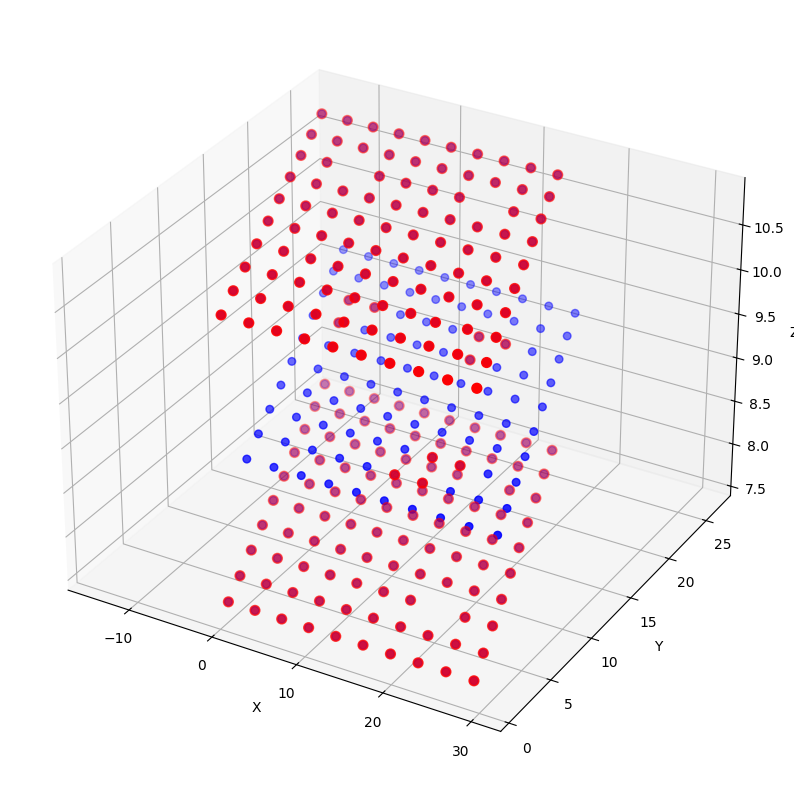

In [28]:
import numpy as np
from scipy.spatial import Voronoi, ConvexHull
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from collections import Counter

# 提取前两列三维坐标
coords_3d = coords
dim=3
# 扩展坐标
extended_coords = extend_coords_periodic(coords, box_sizes, dim)
# 创建一个字典来存储 a 列表中每个元素的索引
a_dict = {tuple(elem): idx for idx, elem in enumerate(coords_3d)}
b_dict = {tuple(elem): idx for idx, elem in enumerate(extended_coords)}
# 找出 b 列表中元素在 a 列表中的索引
indices = [b_dict[tuple(elem)] for elem in b_dict if elem in a_dict]
print(indices)

# 计算 Voronoi 多面体体积
def calculate_voronoi_volumes(extended_coords, indices):
    vor = Voronoi(extended_coords)
    volumes = []
    for region_index in vor.point_region[indices]:
        region = vor.regions[region_index]
        if not -1 in region and len(region) > 0:
            polygon = [vor.vertices[j] for j in region]
            if len(polygon) > 0:
                hull = ConvexHull(polygon)
                volume = hull.volume
                volumes.append(volume)
            else:
                volumes.append(0)
        else:
            volumes.append(0)
    rounded_volumes = [round(volume, 2) for volume in volumes]
    return np.array(rounded_volumes)

# 计算 Voronoi 多面体体积
volumes = calculate_voronoi_volumes(extended_coords, indices)
# data_min = np.min(volumes)
# data_max = np.max(volumes)
# data_normalized = (volumes - data_min) / (data_max - data_min)
# print(data_normalized)
print(volumes)

'''
# 计算每个元素出现的次数
counter = Counter(volumes)
# 找出出现次数最多的元素（排除0）
most_common_element = counter.most_common(1)[0][0] if counter.most_common(1)[0][0] != 0 else counter.most_common(2)[1][0]
# 将列表中的0替换为出现次数最多的元素
volumes = [most_common_element if x == 0 else x for x in volumes]
# print(volumes)
'''

def most_frequent_index(lst):
    # 计算每种元素的数量
    count = Counter(lst)
    # 找到数量最多的元素
    most_frequent_element = count.most_common(1)[0][0]
    # 找到该元素的所有索引
    most_frequent_indices = [i for i, x in enumerate(lst) if x == most_frequent_element]
    # 找到其他元素的所有索引
    other_indices = [i for i, x in enumerate(lst) if x != most_frequent_element]
    return most_frequent_element, most_frequent_indices, other_indices

# 计算并打印数量最多的元素的索引
most_frequent_element, most_frequent_indices, other_indices = most_frequent_index(volumes)
print("数量最多的元素是{},索引为:{}".format(most_frequent_element, most_frequent_indices))
print("其它元素的索引为:{}".format(other_indices))
# for i in other_indices:
#     print(replaced_zeros_volumes[i])

# 可视化 3D Voronoi 图和缺陷原子
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

vor = Voronoi(coords_3d)

# 绘制Voronoi多面体
for region_index in vor.point_region[:len(coords_3d)]:
    region = vor.regions[region_index]
    if not -1 in region and len(region) > 0:
        polygon = [vor.vertices[j] for j in region]
        if len(polygon) > 0:
            hull = ConvexHull(polygon)
            poly3d = [[vor.vertices[vertex] for vertex in hull.vertices]]
            # ax.add_collection3d(Poly3DCollection(poly3d, alpha=0.1, linewidths=0.1, edgecolors='k'))


# 高亮缺陷原子
ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c='b', s=30)
ax.scatter(coords[other_indices, 0], coords[other_indices, 1], coords[other_indices, 2], c='r', s=50) #高亮显示缺陷原子（红色点）。

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

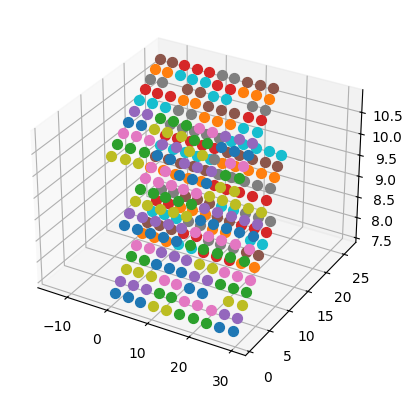

In [29]:
G = create_graph(atoms, volumes)

visualize_3d_graph(G)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def read_ani(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    time_steps = []
    structures = []
    current_structure = []

    for line in lines:
        if line.strip() == '':
            if current_structure:
                structures.append(np.array(current_structure))
                current_structure = []
        else:
            parts = line.split()
            if len(parts) == 1:
                time_steps.append(int(parts[0]))
            else:
                current_structure.append([float(part) for part in parts[1:4]])

    return time_steps, structures

time_steps, structures = read_ani('/fs2/home/ndsim10/mos2_example/work_dir/dataset/raw/0/mos2_75.ANI')

for i, structure in enumerate(structures):
    x = structure[:, 0]
    y = structure[:, 1]
    z = structure[:, 2]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z)
    
    ax.set_title(f'Time Step {time_steps[i]}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
plt.show()

In [21]:
import numpy as np
points = np.array([[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2],
                   [2, 0], [2, 1], [2, 2]])
from scipy.spatial import Voronoi, voronoi_plot_2d
vor = Voronoi(points)
print(vor)

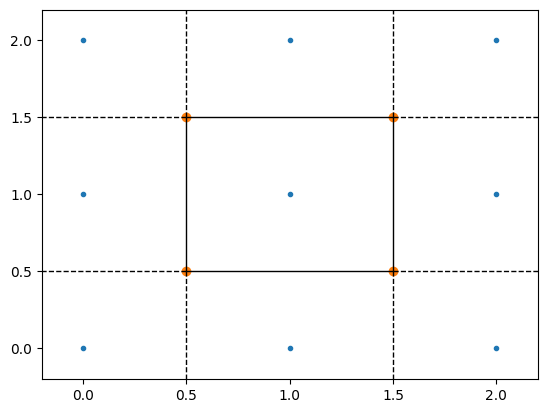

In [22]:
import matplotlib.pyplot as plt
fig = voronoi_plot_2d(vor)
plt.show()

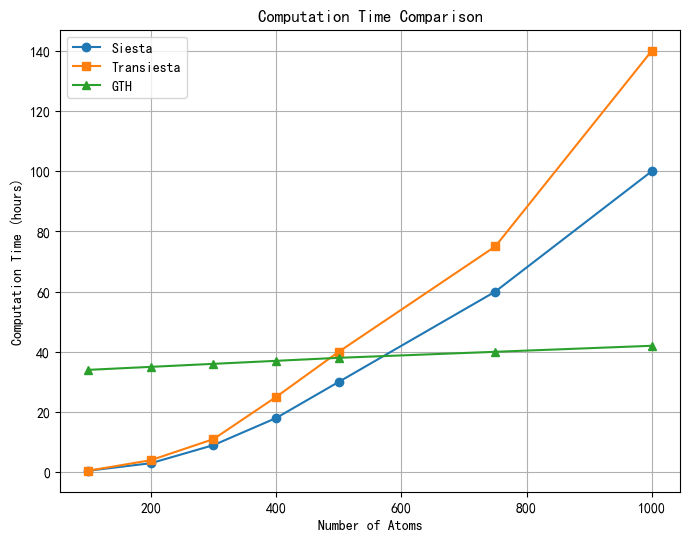

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Defining the atomic counts
atomic_counts = np.array([100, 200, 300, 400, 500, 750, 1000])

# Calculating the computation times for each method
# For siesta and transiesta, assume exponential growth
siesta_times = np.array([0.5, 3, 9, 18, 30, 60, 100])
transiesta_times = np.array([0.5, 4, 11, 25, 40, 75, 140]) # Slightly longer than siesta

# For GTH network model, assume linear growth
gth_times = np.array([34, 35, 36, 37, 38, 40, 42])  # Simple linear relation

# Creating the plot
plt.figure(figsize=(8, 6))
plt.plot(atomic_counts, siesta_times, label='Siesta', marker='o')
plt.plot(atomic_counts, transiesta_times, label='Transiesta', marker='s')
plt.plot(atomic_counts, gth_times, label='GTH', marker='^')

plt.xlabel('Number of Atoms')
plt.ylabel('Computation Time (hours)')
plt.title('Computation Time Comparison')
plt.legend()
plt.grid(True)
plt.show()

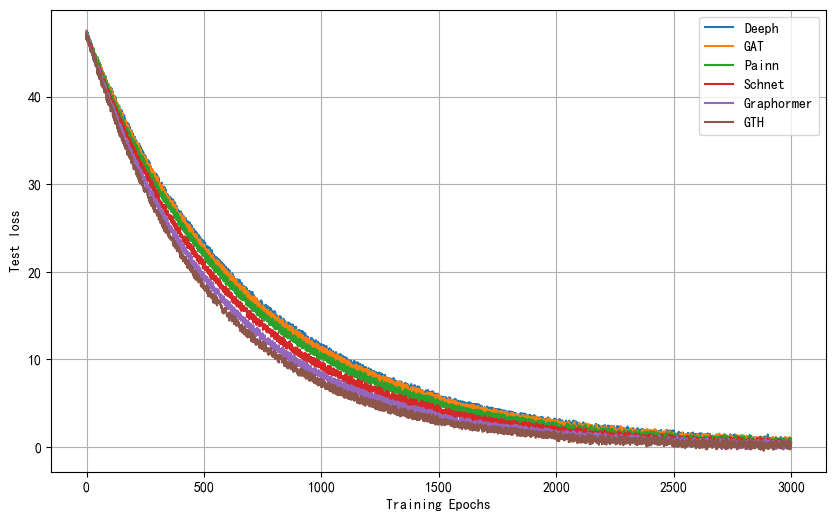

In [32]:
# Adjust the MAE computation function to model different phases of training with changing noise
def model_mae_adjusted(epochs, start_mae, end_mae):
    rate = np.log(start_mae / end_mae) / 2000  # Intensify initial rate, slows after epoch 2000
    mae_values = start_mae * np.exp(-rate * epochs)

    # Different noise levels before and after epoch 2000
    noise1 = np.where(epochs < 1500,
                     np.random.uniform(0, 1, size=epochs.size),
                     np.random.uniform(0, 0.8, size=epochs.size))
    noise2 = np.where(epochs > 2000,
                     np.random.uniform(-0.4, 0, size=epochs.size),
                     np.random.uniform(-0.1, 0, size=epochs.size))
    noise3 = np.where(epochs > 2500,
                     np.random.uniform(-0.3, 0, size=epochs.size),
                     np.random.uniform(-0.1, 0, size=epochs.size))

    return mae_values + noise1 + noise2 + noise3

# Define epochs as an array of epoch numbers from 0 to 2999
epochs = np.arange(3000)

# Recalculate MAE values with specific start and end values
deeph_mae_final = model_mae_adjusted(epochs, 46.7, 2.56)
gat_mae_final = model_mae_adjusted(epochs, 46.7, 2.43)
painn_mae_final = model_mae_adjusted(epochs, 46.7, 2.13)
schnet_mae_final = model_mae_adjusted(epochs, 46.7, 1.68)
graphormer_mae_final = model_mae_adjusted(epochs, 46.7, 1.29)
gth_mae_final = model_mae_adjusted(epochs, 46.7, 1.02)

# Plotting the updated results with specific start and end values and adjusted noise levels
plt.figure(figsize=(10, 6))
plt.plot(epochs, deeph_mae_final, label='Deeph')
plt.plot(epochs, gat_mae_final, label='GAT')
plt.plot(epochs, painn_mae_final, label='Painn')
plt.plot(epochs, schnet_mae_final, label='Schnet')
plt.plot(epochs, graphormer_mae_final, label='Graphormer')
plt.plot(epochs, gth_mae_final, label='GTH')

plt.xlabel('Training Epochs')
plt.ylabel('Test loss')
# plt.title('loss During Training')
plt.legend()
plt.grid(True)
plt.show()